## Van Gogh and other artist
This notebook is dedicated for running generic pipeline on Colab, kaggle token is required for dataset download.

1. Clone the repository to your colab area:

In [16]:
#!git clone https://github.com/czkaiweb/vanGogh-and-Other-Artist.git

# To fetch the change from git repo
%cd /content/vanGogh-and-Other-Artist
!git fetch 
!git pull
!git checkout develop
%cd /content



/content/vanGogh-and-Other-Artist
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/czkaiweb/vanGogh-and-Other-Artist
   14ada9d..a9e994a  develop    -> origin/develop
Updating 14ada9d..a9e994a
Fast-forward
 model/genericCNN.py | 37 ++++++++++++++++++++++++++++++++++---
 1 file changed, 34 insertions(+), 3 deletions(-)
Already on 'develop'
Your branch is up to date with 'origin/develop'.
/content


2. Import the files and needed packages:

In [18]:
import sys
sys.path.append('/content/vanGogh-and-Other-Artist')
sys.path.append('/content/vanGogh-and-Other-Artist/preprocessing')
sys.path.append('/content/vanGogh-and-Other-Artist/model')
from genericCNN import *
from preprocessing.ImageTranform import *
from torchsummary import summary

import shutil
import os
import glob
import pandas as pd
import numpy
from tqdm import tqdm
import hashlib

from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

3.Create image output folder:

In [19]:
# Create Meta record
fileList = []
img_path = "./imgs"

if not os.path.isdir(img_path):
    os.mkdir(img_path)

4. Setup Kaggle token file:

In [4]:
kaggle_path = "/root/.kaggle"
if not os.path.isdir(kaggle_path):
  os.mkdir(kaggle_path)


5. In the left column, click "File", go to parent folder, check if  /root/.kaggle is existed. Upload your kaggle token file (usually it is named kaggle.json) there.
Using "chmod" to set proper authentication to protect your token

In [20]:
!chmod 600 /root/.kaggle/kaggle.json

6. Download the van gogh dataset, unzip the dataset and append the meta data:

In [7]:
# Download van Gogh dataset
!kaggle datasets download -d ipythonx/van-gogh-paintings

# List all von Goph plots
tmp_path = "./tmp"
vangoghZip = 'van-gogh-paintings.zip'
try:
    shutil.unpack_archive(vangoghZip,tmp_path)
except Exception as err:
    print(err)

allVanGogh = glob.glob(tmp_path+'/*/*.jpg')

# Append metadata
for index in tqdm(range(len(allVanGogh))):
    fileName = allVanGogh[index]
    file = fileName.split("/")[-1]
    hashName = hashlib.md5(file.encode()).hexdigest()
    shutil.move(fileName, img_path + "/" + hashName + ".jpg", copy_function = shutil.copy2)
    artist = "vanGogh"
    fileList.append([hashName,artist])
    
# Clean tmp data
try:
    shutil.rmtree(tmp_path)
    os.remove(vangoghZip)
except Exception as err:
    print(err)

 99% 481M/485M [00:13<00:00, 49.2MB/s]
100% 485M/485M [00:13<00:00, 36.4MB/s]


100%|██████████| 2024/2024 [00:00<00:00, 32591.50it/s]


7. Download the monet dataset, unzip the dataset and append the meta data:

In [8]:
!kaggle datasets download -d srrrrr/monet2photo

# List all Monet plots
tmp_path = "./tmp"
monetZip = 'monet2photo.zip'
try:
    shutil.unpack_archive(monetZip,tmp_path)
except Exception as err:
    print(err)

allMonet = glob.glob(tmp_path+'/*/trainA/*.jpg')

# Append metadata
for index in tqdm(range(len(allMonet))):
    fileName = allMonet[index]
    file = fileName.split("/")[-1]
    hashName = hashlib.md5(file.encode()).hexdigest()
    shutil.move(fileName, img_path + "/" + hashName + ".jpg", copy_function = shutil.copy2)
    artist = "Monet"
    fileList.append([hashName,artist])
    
# Clean tmp data
try:
    shutil.rmtree(tmp_path)
    os.remove(monetZip)
except Exception as err:
    print(err)

 98% 257M/263M [00:10<00:00, 35.6MB/s]
100% 263M/263M [00:10<00:00, 27.0MB/s]


100%|██████████| 1072/1072 [00:00<00:00, 34484.75it/s]


8. Download the customized dataset, unzip the dataset and append the meta data:

In [9]:
# Download WikiArts dataset: https://www.kaggle.com/datasets/antoinegruson/-wikiart-all-images-120k-link
!kaggle datasets download -d czkaiweb/subwikiarts

# List all wikiarts plots
tmp_path = "./tmp"
wikiartsZip = 'subwikiarts.zip'
try:
    shutil.unpack_archive(wikiartsZip,tmp_path)
except Exception as err:
    print(err)

WikiArtsMeta = tmp_path+"/WikiArts.csv"
WikiArtsDF = pd.read_csv(WikiArtsMeta)
WikiArtsList = WikiArtsDF[["hash","Artist"]].values

def findGroup(head):
    if head <= "33":
        return "/GroupA/"
    elif head <= "69":
        return "/GroupB/"
    elif head <= "9d":
        return "/GroupC/"
    elif head <= "cc":
        return "/GroupD/"
    else:
        return "/GroupE/"
    
# Set to true for group splitting
preClean = False
if preClean == True:
    for char in ["A","B","C","D","E"]:
        groupDir = img_path+"/Group{}".format(char)
        if not os.path.isdir(groupDir):
            os.mkdir(groupDir)

for record in WikiArtsList:
    groupDir = "/./"
    if preClean:
        groupDir = findGroup(record[0][:2])
    fileName = tmp_path+"/imgs/"+record[0]+".jpg"
    shutil.move(fileName, img_path+ groupDir + "/" , copy_function = shutil.copy2)
    
# Clean tmp data
try:
    shutil.rmtree(tmp_path)
    os.remove(wikiartsZip)
except Exception as err:
    print(err)


100% 993M/995M [00:34<00:00, 23.9MB/s]
100% 995M/995M [00:34<00:00, 30.0MB/s]


9. Create the csv file for meta data:

In [10]:
# Save to meta file
metaDF = pd.DataFrame(fileList,columns = ["hash","Artist"])
metaDF = pd.concat([metaDF,WikiArtsDF[["hash","Artist"]]])
metaDF.to_csv("meta.csv")

10. Import the generic pipeline and transformer if not imported yet, set the image transformer to the genericCNN

In [21]:
#Initialize the object
myObj = genericCNN()

# Set up the transformer
myTransform = ImageTransformer((224,224))
myTransform.initTransform()
transformer = myTransform.getTransformer()

myObj.setTransformer(transformer)
# Decide if adding normalization layer at the end of transformation, by default, normalization will be added
# myObj.UseNormalized(normalize = True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1421: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1436: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


11. Set meta data and input path, split the dataset and load the data to Dataset/DatasetLoader

In [22]:
# Set up the meta data and path to image dataset
myObj.setDataset("meta.csv",path = "imgs")

# Split the data by portion, fraction indicate the percentage of data used in the whole dataset. 
# Default: val_size = 0.2, test_size = 0.1 
myObj.splitData(val_size=0.2,test_size = 0.1,fraction = 1)

# Will automatically get the statistic for training set, update the mean/std used for normalization. 
# loadData and checkDataset
myObj.loadData()

04e84f850d81a2e0a7440e13b46744e4 torch.Size([1, 224, 224])
e2ee5d0fd45f95074b7e5e8665ab22de torch.Size([4, 224, 224])
c9250c6bebf980301c38dc5735024fba torch.Size([1, 224, 224])
b96a4a83299a54b4be4ff78c0d92c170 torch.Size([1, 224, 224])
632fc73d4e2de07f28d85429ff390476 torch.Size([1, 224, 224])
84e717a6cf749d681ffbb2557758bd13 torch.Size([1, 224, 224])
d7999f4ec0a7efcc004c733e813ddb39 torch.Size([4, 224, 224])
9d694f7ee70d5f694dda849a0a132bcb torch.Size([4, 224, 224])
b808f9e26122a39d1f22814ca8f21db6 torch.Size([1, 224, 224])
521cde1dc6bf903b92698cce5fc45cc9 torch.Size([1, 224, 224])
53e872e09c40a912e36d53daf6920243 torch.Size([4, 224, 224])
66855fd1af6fcc7eb4ed461d5c82a810 torch.Size([1, 224, 224])
0641ceb25ff823cf52802ea8c07558b1 torch.Size([1, 224, 224])
0be2cd049d2ecf361c6ffcb1c5054de5 torch.Size([4, 224, 224])
042faaee15402a071df98949a2fe4298 torch.Size([1, 224, 224])
a2e7131ada2d8c94340e87dde1fbee69 torch.Size([1, 224, 224])
bcbf898f298ba2a00e088c50e3e27134 torch.Size([1, 224, 224

12. Display a batch:

0 torch.Size([5, 3, 224, 224]) tensor([0, 0, 3, 0, 0])
torch.Size([5, 3, 224, 224])


<Figure size 432x288 with 0 Axes>

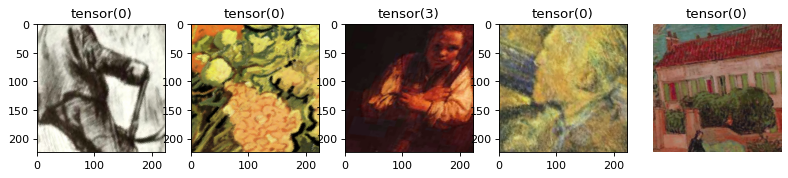

In [23]:
myObj.showDatasetBatch()

13. Select model and edit the architecture:

In [24]:
# Use the pre-trained model
model_ft = models.vgg16(pretrained=True)
#model_ft.load_state_dict(torch.load('./weights/vgg16-397923af.pth'))
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 6)
model_ft = model_ft.to(myObj.device)

# Specifiy the criterion:
criterion = nn.CrossEntropyLoss()

# Specify the optizimer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Specift the learning rate scheduler. Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

14. Set the model for the generic object:

In [25]:
myObj.setModel(model = model_ft,modeltag="vgg16mod")

15: Train the model:

In [ ]:
myObj.train_model(criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


Epoch 0 Phase train: 100%|██████████| 792/792 [03:42<00:00,  3.56batch/s]


train Loss: 1.0916 Acc: 0.6035


Epoch 0 Phase val: 100%|██████████| 226/226 [00:43<00:00,  5.25batch/s]


val Loss: 1.0867 Acc: 0.5864

Epoch 1/9
----------


Epoch 1 Phase train: 100%|██████████| 792/792 [03:42<00:00,  3.56batch/s]


train Loss: 0.7909 Acc: 0.7139


Epoch 1 Phase val: 100%|██████████| 226/226 [00:43<00:00,  5.21batch/s]


val Loss: 0.7151 Acc: 0.7422

Epoch 2/9
----------


Epoch 2 Phase train: 100%|██████████| 792/792 [03:42<00:00,  3.56batch/s]


train Loss: 0.6565 Acc: 0.7710


Epoch 2 Phase val: 100%|██████████| 226/226 [00:42<00:00,  5.32batch/s]


val Loss: 0.5817 Acc: 0.8025

Epoch 3/9
----------


Epoch 3 Phase train:  62%|██████▏   | 489/792 [02:17<01:25,  3.56batch/s]

16. Save the weights as pth file:

In [ ]:
torch.save(myObj.Model.state_dict(), 'model_weights.pth')

17. Download the weight file from colab:

In [ ]:
from google.colab import files
files.download("model_weights.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
myObj.evaluate(saveAs="output.png")